In [1]:
# !pip install tensorflow-gpu

In [2]:
# !pip install tensorflow --upgrade --force-reinstall

In [3]:
# !pip install -q keras

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
import os

## Transfer Learning

In [6]:
# img_dir = "drive/MyDrive/Colab Notebooks/project/data/images/"
# data_dir = "drive/MyDrive/Colab Notebooks/project/data/"
data_dir = "../data/"
img_dir = "../data/IMAGES/"
ny_dir = "../data/NY_IMAGES/"
fl_dir = "../data/FL_IMAGES/"
penn_dir = "../data/PENN_IMAGES/"

## Data preparation

Load prepared files

In [7]:
# from google.colab import drive 
# drive.mount('/content/drive')
import pickle
with open(data_dir + 'ny_img_paths.pkl', 'rb') as f:
  ny_img_files = pickle.load(f)

with open(data_dir + 'fl_img_paths.pkl', 'rb') as f:
  fl_img_files = pickle.load(f)

with open(data_dir + 'penn_img_paths.pkl', 'rb') as f:
  penn_img_files = pickle.load(f)

In [8]:
ny_img_files[:5]

[['004403_0.jpg', 0],
 ['004403_1.jpg', 0],
 ['004403_2.jpg', 0],
 ['004403_3.jpg', 0],
 ['004403_4.jpg', 0]]

In [9]:
fl_img_files[:5]

[['003079_0.jpg', 1],
 ['003079_1.jpg', 1],
 ['003079_2.jpg', 1],
 ['003079_3.jpg', 1],
 ['003079_4.jpg', 1]]

In [10]:
penn_img_files[:5]

[['000001_0.jpg', 2],
 ['000001_1.jpg', 2],
 ['000001_2.jpg', 2],
 ['000001_3.jpg', 2],
 ['000001_4.jpg', 2]]

In [11]:
print("NY Images: ", len(ny_img_files))
print("PENN Images: ", len(penn_img_files))
print("FL Images: ", len(fl_img_files))


NY Images:  28386
PENN Images:  18468
FL Images:  7944


In [12]:
ny_img_files = [x[0] for x in ny_img_files]

In [13]:
ny_img_files[:5]

['004403_0.jpg',
 '004403_1.jpg',
 '004403_2.jpg',
 '004403_3.jpg',
 '004403_4.jpg']

In [14]:
fl_img_files = [x[0] for x in fl_img_files]

In [15]:
fl_img_files[:5]

['003079_0.jpg',
 '003079_1.jpg',
 '003079_2.jpg',
 '003079_3.jpg',
 '003079_4.jpg']

In [16]:
penn_img_files = [x[0] for x in penn_img_files]

In [17]:
penn_img_files[:5]

['000001_0.jpg',
 '000001_1.jpg',
 '000001_2.jpg',
 '000001_3.jpg',
 '000001_4.jpg']

Split some data for testing and validation.

In [18]:
from sklearn.model_selection import train_test_split

ny_train, ny_test = train_test_split(ny_img_files, test_size=0.30, random_state=11)
fl_train, fl_test = train_test_split(fl_img_files, test_size=0.30, random_state=11)
penn_train, penn_test = train_test_split(penn_img_files, test_size=0.30, random_state=11)

### Move Picture to test folder

In [19]:
test_dir = "../data/test"
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [20]:
from tqdm import tqdm
import shutil
ny_test_dir = "../data/test/NY/"

if not os.path.exists(ny_test_dir):
    os.makedirs(ny_test_dir)
    for img in tqdm(ny_test):
        shutil.copyfile(ny_dir + img, ny_test_dir + img)

In [21]:
fl_test_dir = "../data/test/FL/"
if not os.path.exists(fl_test_dir):
    os.makedirs(fl_test_dir)
    for img in tqdm(fl_test):
        shutil.copyfile(fl_dir + img, fl_test_dir + img)

In [22]:
penn_test_dir = "../data/test/PENN/"
if not os.path.exists(penn_test_dir):
    os.makedirs(penn_test_dir)
    for img in tqdm(penn_test):
        shutil.copyfile(penn_dir + img, penn_test_dir + img)

### Move Pictures to Train Directory

In [23]:
train_dir = "../data/train"
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

In [24]:
ny_train_dir = "../data/train/NY/"

if not os.path.exists(ny_train_dir):
    os.makedirs(ny_train_dir)
    for img in tqdm(ny_train):
        shutil.copyfile(ny_dir + img, ny_train_dir + img)

In [25]:
fl_train_dir = "../data/train/FL/"
if not os.path.exists(fl_train_dir):
    os.makedirs(fl_train_dir)
    for img in tqdm(fl_train):
        shutil.copyfile(fl_dir + img, fl_train_dir + img)

In [26]:
penn_train_dir = "../data/train/PENN/"
if not os.path.exists(penn_train_dir):
    os.makedirs(penn_train_dir)
    for img in tqdm(penn_train):
        shutil.copyfile(penn_dir + img, penn_train_dir + img)

100%|██████████| 12927/12927 [00:59<00:00, 216.23it/s]


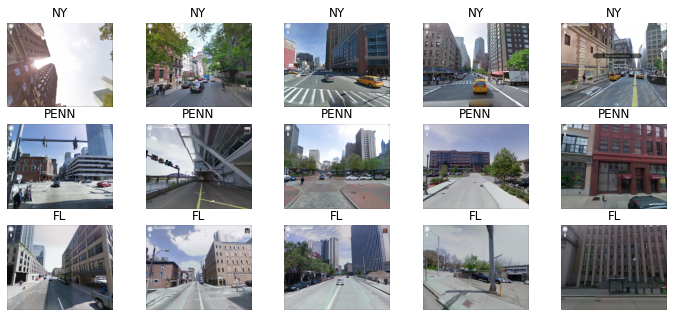

In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ny = np.random.choice([ny_train_dir + img for img in ny_train], 5)
penn = np.random.choice([penn_train_dir + img for img in penn_train], 5)
fl = np.random.choice([penn_train_dir + img for img in penn_train], 5)
data = np.concatenate((ny, penn, fl))
labels = 5 * ['NY'] + 5 * ['PENN'] + 5 * ['FL']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Model customization

In [28]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 3
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Data augmentation

In [29]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 38357 images belonging to 3 classes.
Found 16441 images belonging to 3 classes.


Plot some images result of data augmentation.

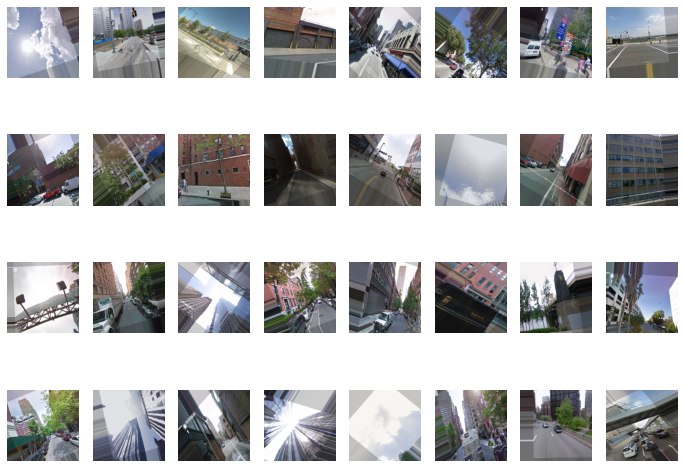

In [30]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

In [31]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'resnet-NY-FL-PENN.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

C:\Users\mjs47\AppData\Local\Temp\ipykernel_17276\1857694985.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
320/320 [==============================] - 1062s 3s/step - loss: 0.8046 - accuracy: 0.6371 - val_loss: 0.6111 - val_accuracy: 0.7300
Epoch 2/5
320/320 [==============================] - 917s 3s/step - loss: 0.6636 - accuracy: 0.7148 - val_loss: 0.5415 - val_accuracy: 0.7920
Epoch 3/5
320/320 [==============================] - 911s 3s/step - loss: 0.6163 - accuracy: 0.7369 - val_loss: 0.6069 - val_accuracy: 0.7490
Epoch 4/5
320/320 [==============================] - 944s 3s/step - loss: 0.6226 - accuracy: 0.7376 - val_loss: 0.5331 - val_accuracy: 0.7769
Epoch 5/5
320/320 [==============================] - 961s 3s/step - loss: 0.6049 - accuracy: 0.7446 - val_loss: 0.4982 - val_accuracy: 0.7896
INFO:tensorflow:Assets written to: resnet-NY-FL-PENN.model\assets


RED: Training Accuracy/Loss
BLUE: Validation Accuracy/Loss


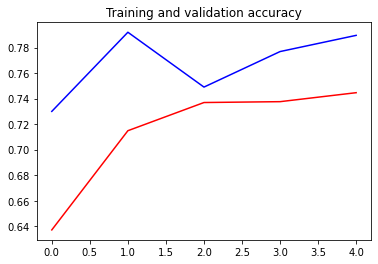

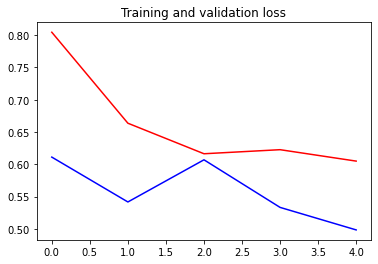

In [38]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r-')
  plt.plot(epochs, val_acc, 'b-')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r-')
  plt.plot(epochs, val_loss, 'b-')
  plt.title('Training and validation loss')
  # plt.legend(loc="upper left")
  plt.show()
  
print("RED: Training Accuracy/Loss")
print("BLUE: Validation Accuracy/Loss")
plot_training(history)

## Prediction of the custom model

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    plt.imshow(img)
    plt.figure()
    labels = ["FL", "NY","PENN"]
    plt.barh(range(3),preds,alpha=0.5)
    plt.yticks(range(3),labels)
    plt.xlabel('Probability')
    plt.xlim(0,1)
    plt.tight_layout()
    plt.show()
    print(preds)

In [111]:
model = load_model(MODEL_FILE)

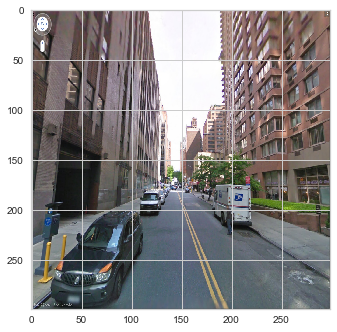

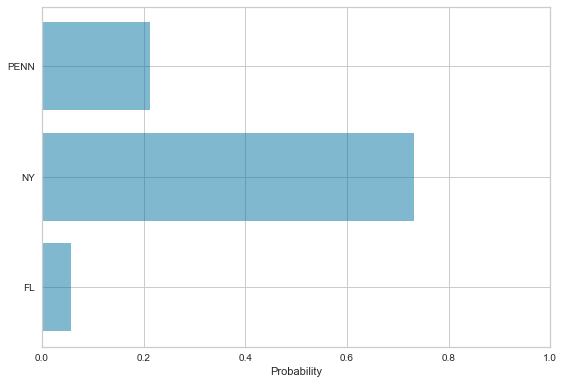

[0.0566664  0.7316121  0.21172144]


In [112]:
img = image.load_img('../data/test/NY/004423_2.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
plot_preds(img, preds)

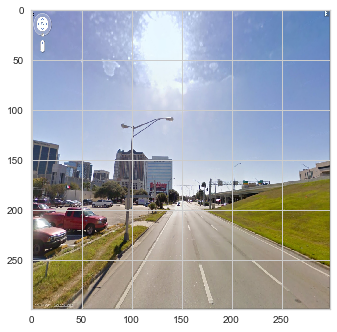

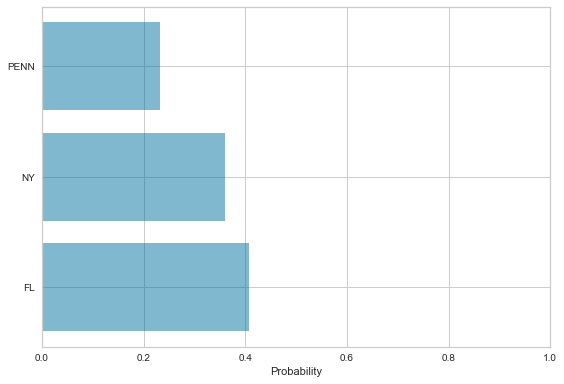

[0.4072668  0.35980976 0.23292339]


In [113]:
img = image.load_img('../data/test/FL/003084_2.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
plot_preds(img, preds)

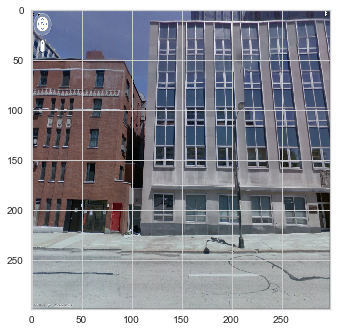

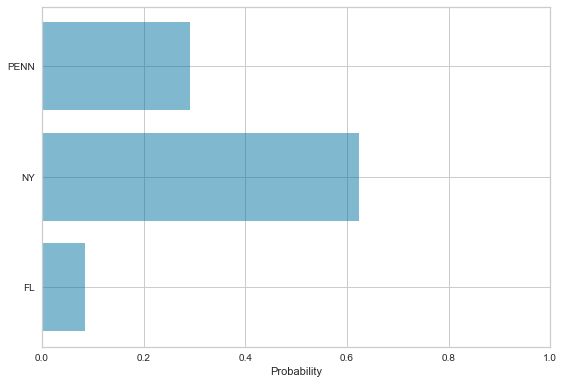

[0.0856571  0.6236344  0.29070848]


In [114]:
img = image.load_img('../data/test/PENN/000019_3.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
plot_preds(img, preds)

In [105]:
model.evaluate_generator
history = model.evaluate(validation_generator)

514/514 [==============================] - 3382s 7s/step - loss: 0.5061 - accuracy: 0.7896
